In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
!pip install -r requirements.txt

In [3]:
import nest_asyncio
nest_asyncio.apply()
import asyncio


import re
import json


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output, display
import time

bridge_trajs = np.load("assets/bridge_v2_10_trajs.npy", allow_pickle=True)

In [5]:
from vlm_autoeval_robot_benchmark.utils.ecot_primitives import ecot_primitive_movements, inverse_ecot_primitive_movements
from vlm_autoeval_robot_benchmark.models.vlm import VLM, create_vlm_request, parse_vlm_response


In [6]:
def show_trajectory_video(descriptors, delay=0.2, wait_for_key=False):
    """Show observations as a video with either delay between frames or keystroke.
    
    Args:
        descriptors: Dictionary containing trajectory information
        delay: Time delay between frames if wait_for_key is False
        wait_for_key: If True, wait for any key press between frames
    """
    plt.figure(figsize=(10, 10))
    for i, obs in enumerate(descriptors["obs"]):
        clear_output(wait=True)
        plt.imshow(obs)
        title = f"Frame {i} - {descriptors['task_language_instruction']}"
        for k,v in descriptors['moves'][i].items():
            title += f"\n------------------------\n{k} - {v}"
        plt.title(title)
        plt.axis('off')
        display(plt.gcf())
        
        if wait_for_key:
            input("Press Enter to continue...")  # Wait for any key
        else:
            time.sleep(delay)
    plt.close()

In [7]:
def repackage_to_episode(traj):
    steps = []
    for i in range(len(traj["observations"])):
        step = {}
        step["observation"] = traj["observations"][i]
        step["action"] = traj["actions"][i]
        steps.append(step)
    return dict(steps=steps)

In [8]:
THRESHOLD = 0.00
WINDOW = 2


def get_descriptors(traj):
    move_primitives = ecot_primitive_movements.get_move_primitives_episode(repackage_to_episode(traj), threshold=THRESHOLD, window=WINDOW)
    move_primitives = [dict(ecot=move) for move in move_primitives]
    obs_list = [t["images0"] for t in traj["observations"]]  # list of obs
    gt_actions = traj["actions"]  # list of ground truth actions
    task_language_instruction = traj["language"][0] if "language" in traj else None
    return dict(moves=move_primitives, obs=obs_list, gt_actions=gt_actions, task_language_instruction=task_language_instruction)

In [9]:
traj_idx = 1  # Change this to visualize different trajectories
episode_descriptors = get_descriptors(bridge_trajs[traj_idx])
# show_trajectory_video(episode_descriptors, delay=0.15)

In [10]:
for i, traj in enumerate(bridge_trajs):
    descriptors = get_descriptors(traj)
    print(i, descriptors['task_language_instruction'])

0 abriu a gaveta
1 close the drawer
2 removed the green thing from the drawer and placed it on the left side of the table.
3 take the red object out of the pot and put it on the left burner
4 take the blue stuffed animal and leaves it inside the drawer.
5 open the drawer
6 close the drawer
7 Open the drawer
8 close the drawer
9 removed the blue object from the drawer and put it on the lower left side of the table


In [11]:
from primitive_moves_tester import run_test, print_test_results

In [12]:
traj = bridge_trajs[traj_idx]
episode_descriptors = get_descriptors(bridge_trajs[traj_idx])

In [13]:
import io
import numpy as np
from PIL import Image

def numpy_array_to_png_bytes(arr: np.ndarray) -> bytes:
    """
    Convert a NumPy array to PNG file bytes, as if it was saved as a PNG and then read with fp.read()
    
    Args:
        arr: NumPy array with shape (height, width, 3) and dtype uint8
        
    Returns:
        PNG file bytes
    """
    # Ensure the array is the right shape and type
    if len(arr.shape) != 3 or arr.shape[2] != 3:
        raise ValueError(f"Expected array with shape (height, width, 3), got {arr.shape}")
    
    if arr.dtype != np.uint8:
        arr = arr.astype(np.uint8)
    
    # Convert the NumPy array to a PIL Image
    img = Image.fromarray(arr)
    
    # Create a BytesIO object to store the image bytes
    buffer = io.BytesIO()
    
    # Save the image to the BytesIO object as PNG
    img.save(buffer, format="PNG")
    
    # Get the bytes from the BytesIO object
    png_bytes = buffer.getvalue()
    
    return png_bytes

In [14]:
sub_episode_descriptors = dict()
sub_step_interval = 2   

for k,v in episode_descriptors.items():
    if isinstance(v, list):
        sub_episode_descriptors[k] = v[::sub_step_interval]
    else:
        sub_episode_descriptors[k] = v

In [15]:
# model = "gpt-4o"
# model = "gemini/gemini-2.0-flash"
# model = "gemini/gemini-2.0-pro-exp"
model = "gemini/gemini-2.5-pro-preview-03-25"

env_desc = "You are looking at a wooden desk with a black robot arm. The desk has a drawer with a handle and some objects on it."
task_desc = sub_episode_descriptors["task_language_instruction"]
img_bytes = [numpy_array_to_png_bytes(img) for img in sub_episode_descriptors["obs"]]

In [16]:
from vlm_autoeval_robot_benchmark.models.vlm import parse_vlm_responses

async def run_episode(model, env_desc, task_desc, img_bytes_list):
    vlm = VLM()
    reqs = [create_vlm_request(model, img_bytes, env_desc, task_desc) for img_bytes in img_bytes_list]
    responses = await vlm.generate_parallel(reqs)
    results = parse_vlm_responses(responses)
    return results, responses

# Run all tests in parallel
results, responses = asyncio.run(run_episode(
    model,
    env_desc,
    task_desc,
    img_bytes,  # assuming img_bytes is your list of image bytes
))
print_test_results(results)

Result 0:
Okay, let's analyze the scene and determine the next action.

**Scene Description:**
The scene shows a wooden desk surface viewed from a slightly elevated front-left angle. On the desk, there's a red drawer unit with its drawer partially open, revealing a blue cloth inside. The drawer has a prominent black handle. To the left of the drawer unit are several small objects: a blue toy elephant, a yellow toy banana, a green oblong shape, and a blue arch block. A black robot arm with a parallel jaw gripper is positioned above the desk. The gripper is currently open and located slightly above, behind, and to the right of the drawer handle. The task is to close the drawer. The robot has not yet made contact with the drawer or its handle.

**Action Analysis:**
The immediate goal is to position the gripper correctly to grasp the drawer handle. Currently, the gripper is too high, slightly too far back, and possibly slightly too far to the right relative to the handle. Therefore, the ro

In [17]:
bad = [r for r in results if 'answer' not in r]
print(f"num bad: {len(bad)}")
if len(bad) > 0:
    print(bad[0]['error'])
    print(bad[0]['raw_response'])

num bad: 0


In [24]:
for t, res in enumerate(results):
    description = res['description']
    sub_episode_descriptors['moves'][t]['vlm - desc'] = "\n".join([description[x:x+100] for x in range(0, len(description), 100)])
    action_texts = []
    for k in ['x', 'y', 'z', 'tilt', 'roll', 'rotation', 'gripper']:
        action_texts.append(f"{res['answer'][k][0]}" + (f"({res['answer'][k][1]})" if res['answer'][k][1] != 0.0 else ""))
    sub_episode_descriptors['moves'][t]['vlm'] = " , ".join([a for a in action_texts if a != 'None'])

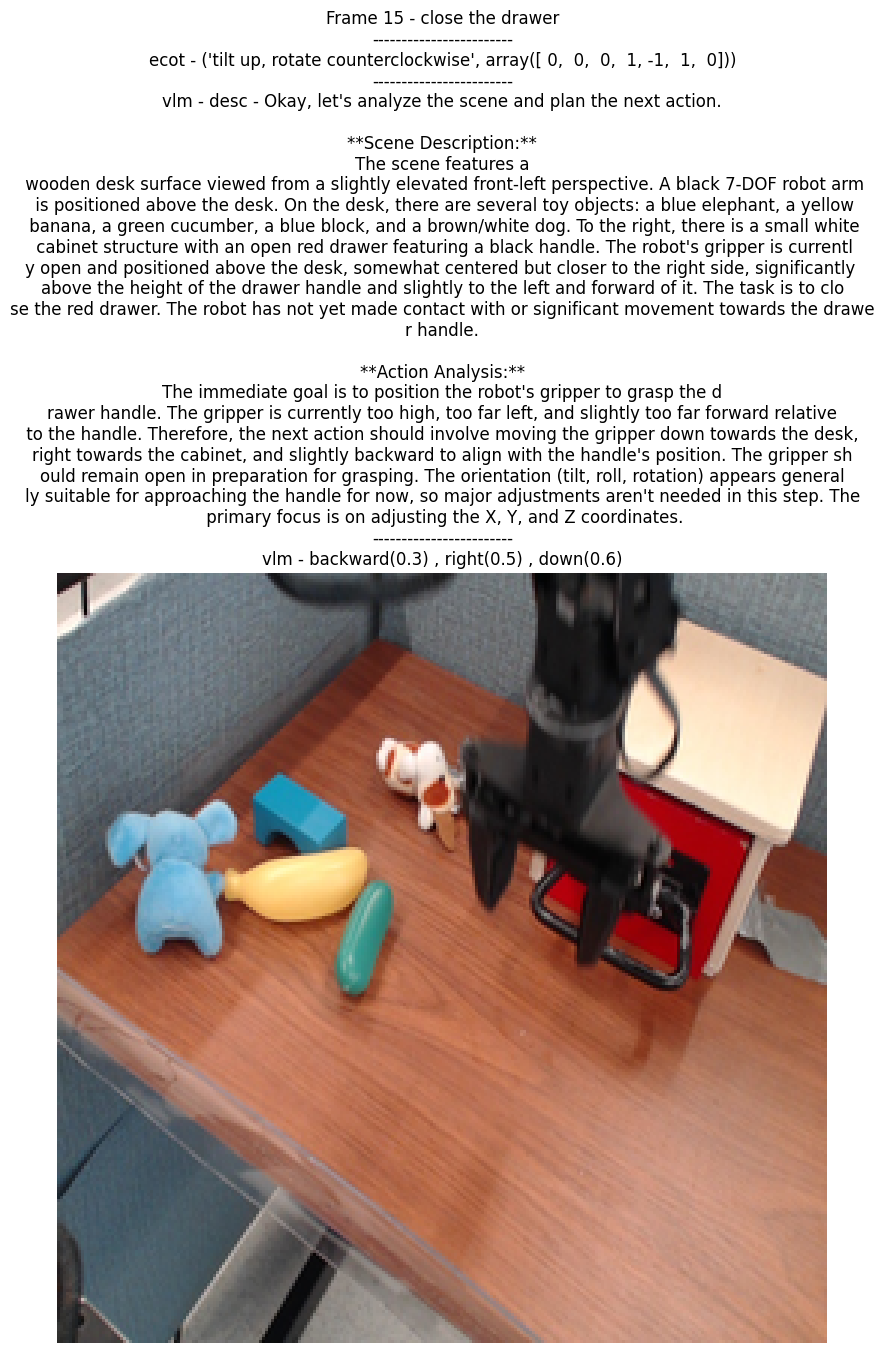

In [25]:
show_trajectory_video(sub_episode_descriptors, delay=5, wait_for_key=True)

In [20]:
traj = bridge_trajs[0]

In [21]:
states = np.array([obs['state'] for obs in traj['observations']])
actions = np.array(traj['actions'])

In [22]:
states.shape, actions.shape

((48, 7), (48, 7))

In [23]:
i = 2
print(states[i].round(5))
print(states[i+1].round(5))
print((states[i+1] - states[i]).round(5))

print(actions[i].round(5))

[ 0.30858 -0.06845  0.12421 -0.00634 -0.29784  0.0348   1.00148]
[ 0.31149 -0.08986  0.12013 -0.00694 -0.35101  0.16111  1.00148]
[ 0.00291 -0.02141 -0.00408 -0.0006  -0.05317  0.12631  0.     ]
[ 3.8900e-03 -2.1710e-02 -4.4000e-04 -3.1600e-03 -6.9090e-02  1.9924e-01
  1.0000e+00]
